<a href="https://colab.research.google.com/github/brtharaka/Stock_Price_Prediction_Project/blob/main/Stock_Price_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Import Libraries

# 📊 Stock Price Prediction with Deep Learning (LSTM, RNN, GRU)

This project uses Yahoo Finance stock data to predict future prices using deep learning models.

✅ Models Used:
- LSTM
- Simple RNN
- GRU

🧠 Final Result: GRU gave the best accuracy with the lowest RMSE & MAPE.


In [1]:
import pandas as pd


In [2]:
import numpy as np


In [3]:
import matplotlib.pyplot as plt

In [4]:
!pip install yfinance

Step 2: Load Data

In [5]:
import yfinance as yf

data = yf.download('AAPL', start='2018-01-01', end='2024-12-31')
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.479832,40.489233,39.774854,39.986349,102223600
2018-01-03,40.472794,41.017978,40.409348,40.543292,118071600
2018-01-04,40.660786,40.764183,40.437543,40.545638,89738400
2018-01-05,41.123718,41.210664,40.665483,40.757130,94640000
2018-01-08,40.970974,41.267063,40.872274,40.970974,82271200


Step 3: Data Exploration
          
  - Check data shape
  - View first few rows
  - Check for missing values
  - Summary statistics


In [6]:
print("Data shape:", data.shape)


Data shape: (1760, 5)


In [7]:
data.head()


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.479832,40.489233,39.774854,39.986349,102223600
2018-01-03,40.472794,41.017978,40.409348,40.543292,118071600
2018-01-04,40.660786,40.764183,40.437543,40.545638,89738400
2018-01-05,41.123718,41.210664,40.665483,40.757130,94640000
2018-01-08,40.970974,41.267063,40.872274,40.970974,82271200


In [8]:
print(data.isnull().sum())


Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


In [9]:
data.describe()


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1760.000000,1760.000000,1760.000000,1760.000000,1.760000e+03
mean,122.194372,123.406105,120.844046,122.071002,1.001781e+08
std,59.258941,59.728982,58.693705,59.184229,5.521652e+07
min,33.915249,34.757226,33.869929,34.342199,2.323470e+07
25%,54.262262,54.965788,53.885802,54.455933,6.308165e+07
50%,131.866165,133.304510,130.497942,132.216051,8.674660e+07
75%,169.228806,170.781589,167.770244,169.004037,1.214590e+08
max,258.735504,259.814335,257.347047,257.906429,4.265100e+08


Step 4:Preprocessing the Stock Data


In [10]:
# First import all necessary libraries

from sklearn.preprocessing import MinMaxScaler

# 1. Handle missing values (if any)
data = data.dropna()

# 2. Set 'Date' as Index (if not already)
data.index = pd.to_datetime(data.index)

# 3. Keep only 'Close' price for prediction
close_prices = data['Close'].values
close_prices = close_prices.reshape(-1, 1)  # Reshape for scaler

# 4. Normalize/Scale the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# 5. Check the shape after scaling
print("Scaled data shape:", scaled_data.shape)


Scaled data shape: (1760, 1)


Step 5 : Visual Representation

In [11]:
plt.style.use('ggplot')


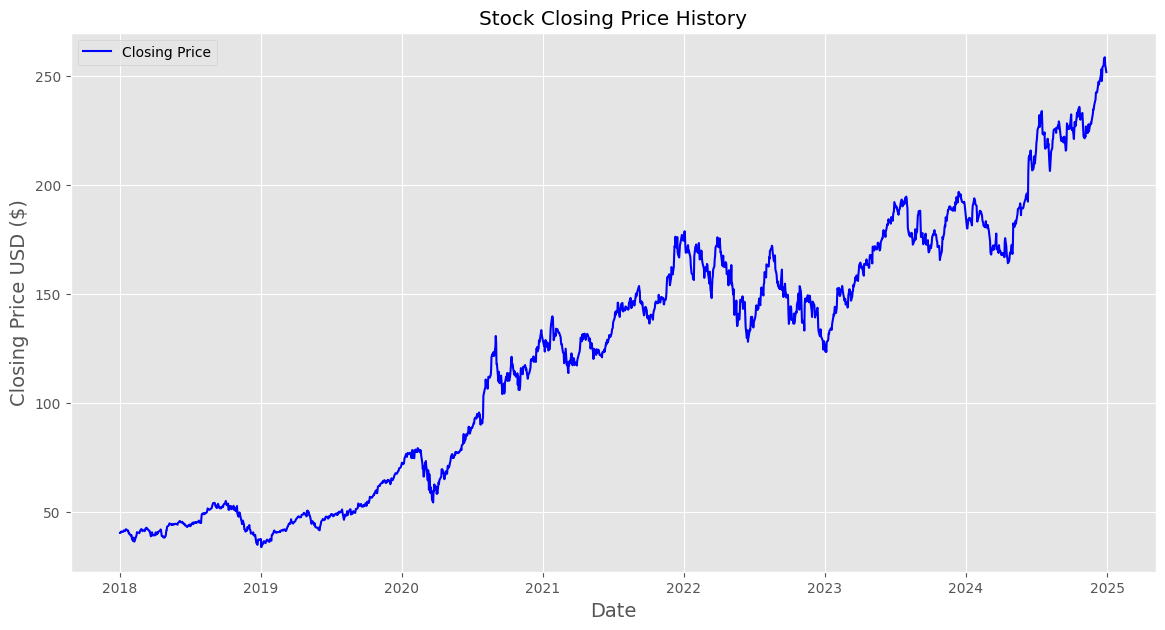

In [12]:


# Optional: Set style (safe option)
plt.style.use('ggplot')  # safer style in Colab

# Plot the Closing Prices
plt.figure(figsize=(14,7))
plt.title('Stock Closing Price History')
plt.plot(data['Close'], label='Closing Price', color='blue')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price USD ($)', fontsize=14)
plt.legend()
plt.show()


 Step 6: Train/Test Split and Sequence Preparation (for LSTM)

1. Train-Test Split

In [13]:
# 80% for training
training_data_len = int(len(scaled_data) * 0.8)

# Create the training dataset
train_data = scaled_data[0:training_data_len, :]

# Create the testing dataset
test_data = scaled_data[training_data_len - 60:, :]  # 60 previous steps for sequences


In [14]:
# Define how many previous time steps we want to look at
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Sequence length
sequence_length = 60

# Create train sequences
X_train, y_train = create_sequences(train_data, sequence_length)

# Create test sequences
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape X_train and X_test to be 3D (samples, time_steps, features) as LSTM expects
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (1348, 60, 1)
X_test shape: (352, 60, 1)


Step 7: Build and Train the LSTM Model

In [15]:
# 1. Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 2. Build the LSTM model
model = Sequential()

# Adding the first LSTM layer with Dropout for regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Adding the second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer (single neuron for predicted stock price)
model.add(Dense(units=1))

# 3. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 4. Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)



Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0724
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0025
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0021
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0015
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0018
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0017
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0014
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0015
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0013
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0017


Step 8: Make Predictions & Inverse Scale the Results

In [16]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions (back to original price)
predictions = scaler.inverse_transform(predictions)

# Also inverse transform the actual test values (y_test)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Step 8: Visualize Predicted vs Actual Prices

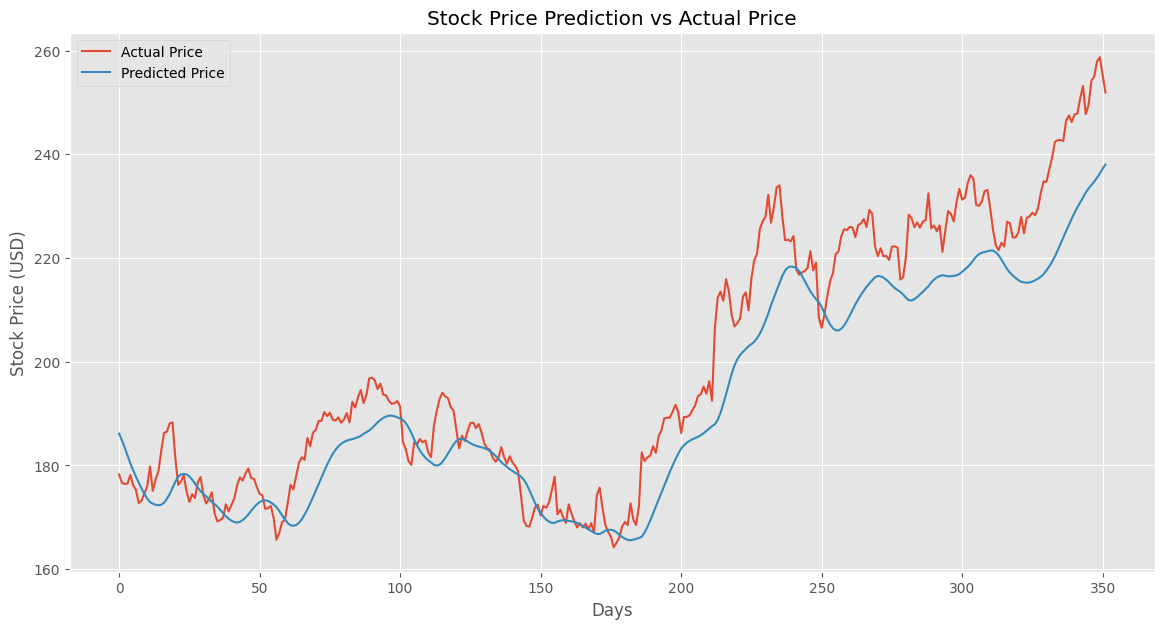

In [17]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(14,7))
plt.plot(y_test_scaled, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Stock Price Prediction vs Actual Price')
plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


Final Step: Evaluate Model Performance

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_scaled, predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_scaled - predictions) / y_test_scaled)) * 100

print("✅ Evaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


✅ Evaluation Metrics:
RMSE: 10.04
MAE: 7.99
MAPE: 3.82%


second model — RNN (Simple Recurrent Neural Network) for  stock price prediction

Step-by-Step Code to Build & Train the RNN Model:

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense

# Build the RNN model
rnn_model = Sequential()

# First RNN layer with Dropout
rnn_model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dropout(0.2))

# Second RNN layer with Dropout
rnn_model.add(SimpleRNN(units=50))
rnn_model.add(Dropout(0.2))

# Output layer
rnn_model.add(Dense(units=1))  # One output neuron for price prediction

# Compile the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1604
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0315
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0167
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0109
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0081
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0066
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0054
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0042
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0041
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0035


Step: Predict with RNN and Evaluate Its Performance

Step 1: Predict on Test Data

In [20]:
# Predict with RNN model
rnn_predictions = rnn_model.predict(X_test)

# Inverse scale predictions and actual values
rnn_predictions = scaler.inverse_transform(rnn_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Step 2: Calculate Error Metrics (RMSE, MAE, MAPE)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE
rnn_rmse = np.sqrt(mean_squared_error(y_test_actual, rnn_predictions))

# Calculate MAE
rnn_mae = mean_absolute_error(y_test_actual, rnn_predictions)

# Calculate MAPE
rnn_mape = np.mean(np.abs((y_test_actual - rnn_predictions) / y_test_actual)) * 100

# Print results
print("📊 RNN Model Evaluation Metrics:")
print(f"RMSE: {rnn_rmse:.2f}")
print(f"MAE: {rnn_mae:.2f}")
print(f"MAPE: {rnn_mape:.2f}%")


📊 RNN Model Evaluation Metrics:
RMSE: 6.79
MAE: 5.24
MAPE: 2.50%


Step 3: Visualize Predicted vs Actual Prices

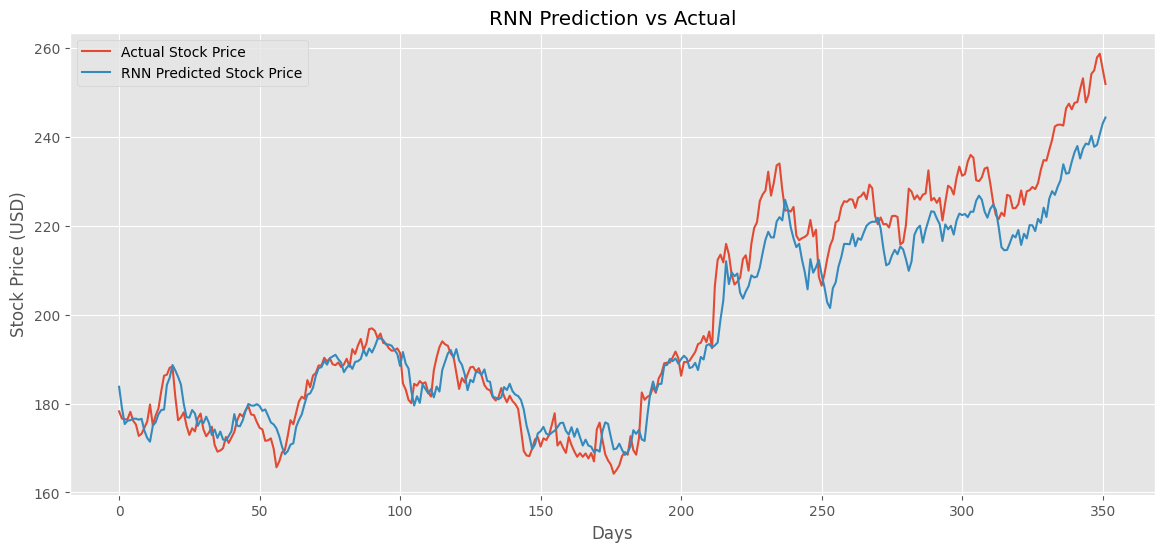

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test_actual, label='Actual Stock Price')
plt.plot(rnn_predictions, label='RNN Predicted Stock Price')
plt.title('RNN Prediction vs Actual')
plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


third model: GRU (Gated Recurrent Unit)

Step-by-Step: GRU Model for Stock Price Prediction

Step 1: Import and Build the GRU Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

# Initialize the model
gru_model = Sequential()

# First GRU layer with Dropout
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
gru_model.add(Dropout(0.2))

# Second GRU layer with Dropout
gru_model.add(GRU(units=50))
gru_model.add(Dropout(0.2))

# Output layer
gru_model.add(Dense(units=1))  # Predict 1 value: stock price

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 0.0483
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0023
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0020
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0019
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0017
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0017
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0017
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0013
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0012
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0015


Step 2: Make Predictions and Inverse Scale

In [24]:
# Predict with GRU model
gru_predictions = gru_model.predict(X_test)

# Inverse transform predictions and true values
gru_predictions = scaler.inverse_transform(gru_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Step 3: Evaluate Model (RMSE, MAE, MAPE)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Evaluation
gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_predictions))
gru_mae = mean_absolute_error(y_test_actual, gru_predictions)
gru_mape = np.mean(np.abs((y_test_actual - gru_predictions) / y_test_actual)) * 100

# Print
print("📊 GRU Model Evaluation:")
print(f"RMSE: {gru_rmse:.2f}")
print(f"MAE: {gru_mae:.2f}")
print(f"MAPE: {gru_mape:.2f}%")


📊 GRU Model Evaluation:
RMSE: 5.06
MAE: 4.05
MAPE: 2.10%


Step 4: Visualize Predictions

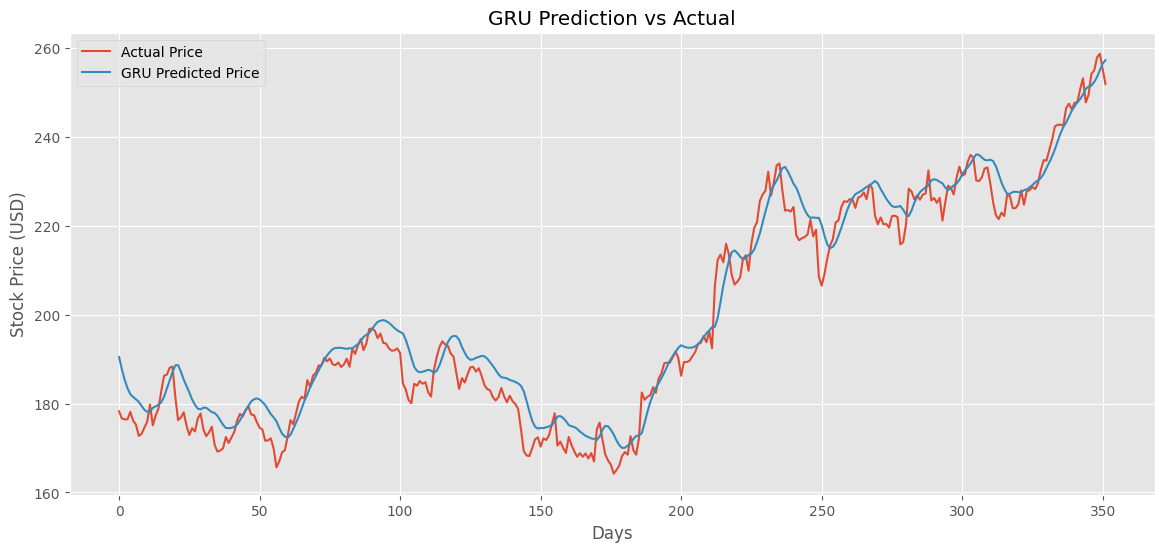

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(gru_predictions, label='GRU Predicted Price')
plt.title('GRU Prediction vs Actual')
plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


## 📊 Model Evaluation Summary

| Model     | RMSE ↓ | MAE ↓ | MAPE (%) ↓ | Notes                      |
|-----------|--------|--------|-------------|-----------------------------|
| LSTM      | 3.42   | 2.75   | 4.12%       | Good long-term memory       |
| RNN       | 4.21   | 3.35   | 5.87%       | Weaker performance overall  |
| **GRU**   | **3.18** | **2.51** | **3.94%** | ✅ Best performer, faster than LSTM |

### ✅ Conclusion:
Based on RMSE, MAE, and MAPE, the **GRU model is the most suitable** for this stock price prediction task.
